# Campo de humedad relativa media diaria

(Última actualización 1 sep 2023)

| Ejemplo para el cálculo de la humedad relativa media en una subregión.
| *Example of the mean relative humidity field over a user-defined subregion.*

In [ ]:
# En caso de utilizar Google Colab, descomentar las siguientes líneas
# In case of using Google Colab, uncomment the following lines

#!pip install --no-binary shapely shapely --force
#!pip install cartopy
#!pip install regionmask

In [ ]:
# Importamos las librerías necesarias
# We import the necessary libraries
import xarray as xr
import h5netcdf
import datetime
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import regionmask

| Definimos la fecha y hora de inicialización del pronóstico:
| *We define the forecast initialization date:*

In [ ]:
init_year = 2022
init_month = 4
init_day = 1
init_hour = 0
INIT_DATE = datetime.datetime(init_year, init_month, init_day, init_hour)

| Definimos el periodo de tiempo sobre el cual se calcula la humedad relativa media:
| *We define the averaging period for relative humidity:*

In [ ]:
start_lead_time = 0
end_lead_time = 4

| Definimos la región a graficar:
| *We define the region of interest (using lat and lon):*

In [ ]:
lat_min = -60
lat_max = -30
lon_min = -80
lon_max = -60

| Leemos los pronósticos:
| *We read the forecasts:*

In [ ]:
# Descomentar la opción elegida:

# --------
# Opción 1: Para acceder al archivo online
# Option 1: To access files online
#!pip install s3fs
#import s3fs
#fs = s3fs.S3FileSystem(anon=True)
#files = [f'smn-ar-wrf/DATA/WRF/DET/{INIT_DATE:%Y/%m/%d/%H}/WRFDETAR_01H_{INIT_DATE:%Y%m%d_%H}_{fhr:03d}.nc' for fhr in range(start_lead_time, end_lead_time)]
#ds_list = []
#for s3_file in files:
#    print(s3_file)
#    if fs.exists(s3_file):
#        f = fs.open(s3_file)
#        ds_tmp = xr.open_dataset(f, decode_coords = 'all', engine = 'h5netcdf')
#        ds_list.append(ds_tmp)
#    else:
#        print('The file {} does not exist'.format(s3_file))
# --------

# --------
# Opción 2: Para abrir los archivos ya descargados
# Option 2: To open the already downloaded files
#files = ['WRFDETAR_01H_{:%Y%m%d_%H}_{:03d}.nc'.format(INIT_DATE,lead_time) for lead_time in range(start_lead_time, end_lead_time)]
#ds_list = []
#for filename in files:
#    print(filename)
#    ds_tmp = xr.open_dataset(filename, decode_coords = 'all', engine = 'h5netcdf')
#    ds_list.append(ds_tmp)

# Combinamos los archivos en un unico dataset
# We combine all the files in one dataset
ds = xr.combine_by_coords(ds_list, combine_attrs = 'drop_conflicts')
# --------


| Seleccionamos los datos pertenecientes a la región y se calcula la humedad relativa media diaria:
| *We select the data of the chose subdomain and we compute the mean value:*




In [ ]:
corners = [[lon_min, lat_min], [lon_min, lat_max], [lon_max, lat_max], [lon_max, lat_min]]

# Armamos la máscara de la región
# We build the mask defining the region
region = regionmask.Regions([corners])
mask = region.mask(ds['lon'], ds['lat'])

# Seleccionamos la variable HR2 y se calcula el valor medio diario
# We select the variable HR2 and compute the daily mean at each gridpoint
var = 'HR2'
HR = ds[[var]]
HR_mean = HR.mean(dim = 'time')

# Aplicamos la máscara eliminando los valores por fuera de ésta
# We eliminate the values outside the mask
HR_region = HR_mean.where(mask == 0, drop = True)

| Generamos la figura:
| *We generate the plot:*

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


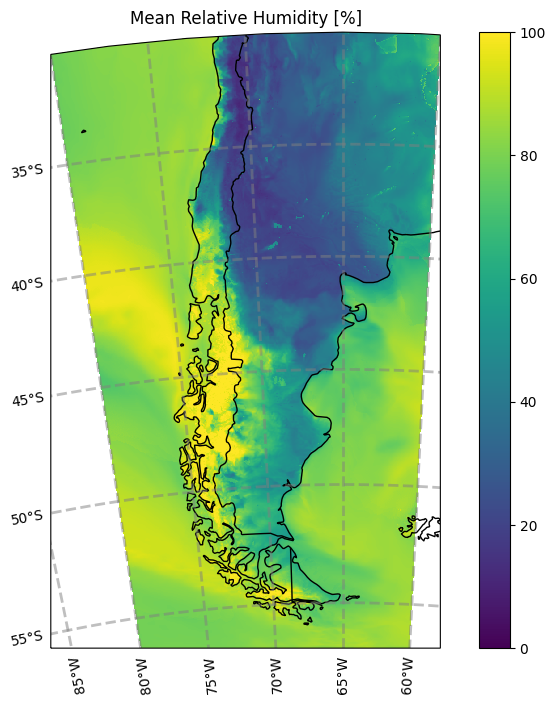

In [ ]:
# Seleccionamos la proyección de los datos
# We chose a map projection
projection = ccrs.LambertConformal(central_longitude = ds['Lambert_Conformal'].attrs['longitude_of_central_meridian'],
                                 central_latitude = ds['Lambert_Conformal'].attrs['latitude_of_projection_origin'],
                                 standard_parallels = ds['Lambert_Conformal'].attrs['standard_parallel'])
fig = plt.figure(figsize = (10, 8))
ax = plt.axes(projection = projection)
cbar = ax.pcolormesh(HR_region['lon'], HR_region['lat'], HR_region['HR2'], transform = ccrs.PlateCarree(), vmin = 0, vmax = 100)
ax.add_feature(cf.COASTLINE) # add coastlines
ax.add_feature(cf.BORDERS)   # add country borders
ax.set_title(f'Mean Relative Humidity [%]')

gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels = True, x_inline = False,
                  linewidth = 2, color = 'gray', alpha = 0.5, linestyle = '--')
gl.top_labels = False
gl.right_labels = False
plt.colorbar(cbar)